Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.pipeline import Pipeline

Load & Prepare Dataset

In [2]:
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
df = pd.concat([X, y], axis=1)

df.to_csv("data/iris.csv", index=False)
display(df.head())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Train-test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standardization

In [4]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Define Distance Metrics

In [5]:
distance_metrics = {
'euclidean': 'euclidean',
'manhattan': 'manhattan',
'chebyshev': 'chebyshev',
'minkowski_p3': {'metric': 'minkowski', 'p': 3},
'minkowski_p4': {'metric': 'minkowski', 'p': 4},
'cosine': 'cosine'
}

Mahalanobis Covariance Computation

In [6]:
cov = np.cov(X_train_std, rowvar=False)
VI = inv(cov)

# Add Mahalanobis to metrics list
distance_metrics_full = distance_metrics.copy()
distance_metrics_full['mahalanobis'] = {'metric': 'mahalanobis', 'V': cov}

Evaluate KNN across Metrics

In [7]:
k_values = range(1, 31)
results = {}

for name, metric in distance_metrics_full.items():
    acc_list = []
    for k in k_values:
        if isinstance(metric, dict) and name.startswith('minkowski'):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric['metric'], p=metric['p'])
        elif name == 'mahalanobis':
            knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'V': cov})
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

        knn.fit(X_train_std, y_train)
        y_pred = knn.predict(X_test_std)
        acc_list.append(accuracy_score(y_test, y_pred))
    results[name] = acc_list

Individual Accuracy Curves

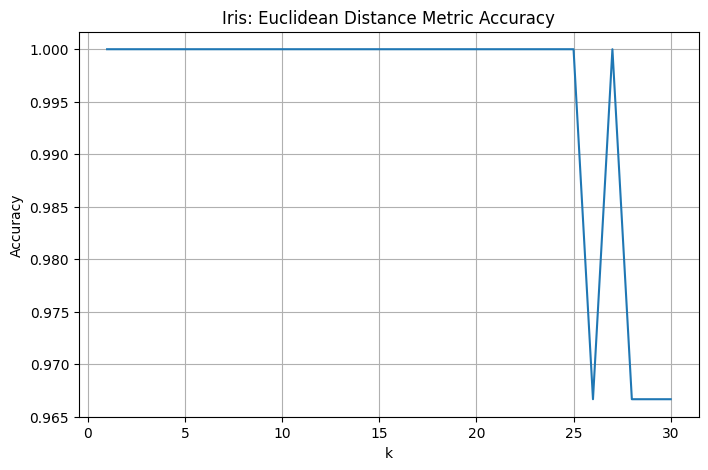

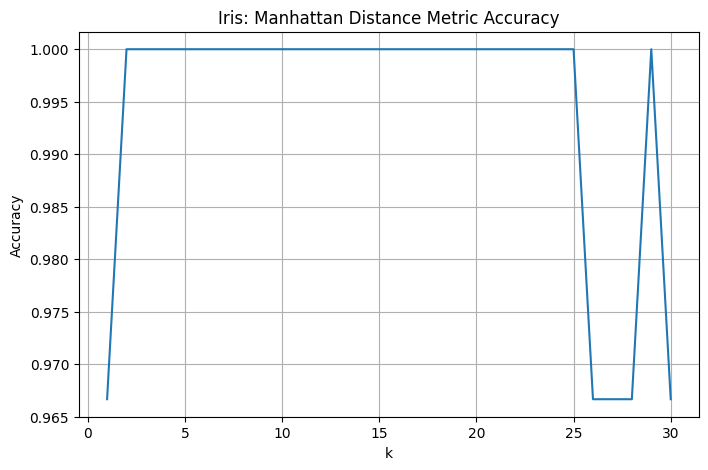

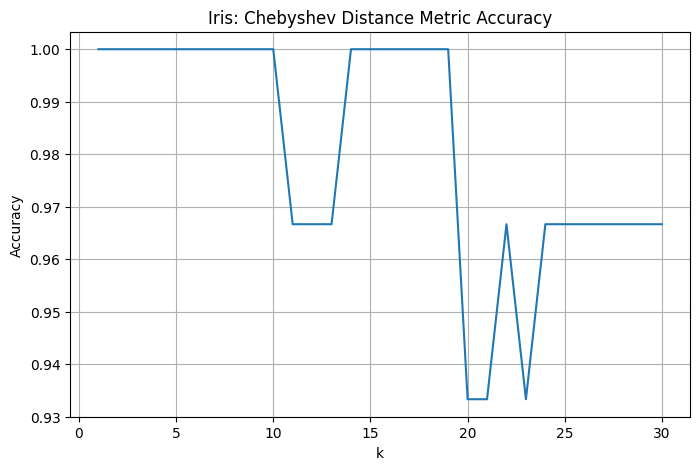

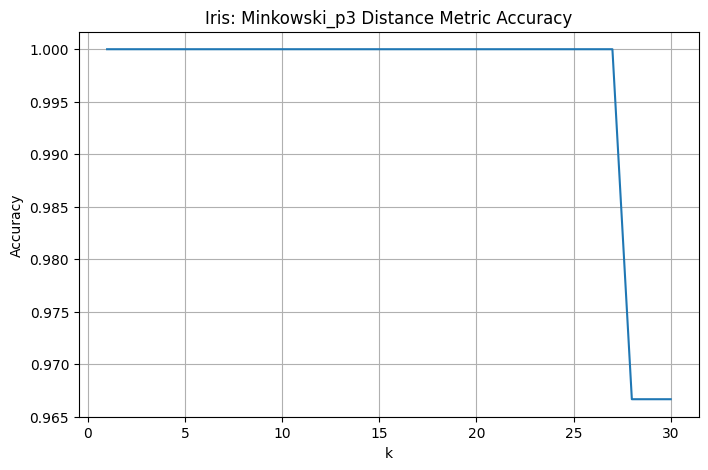

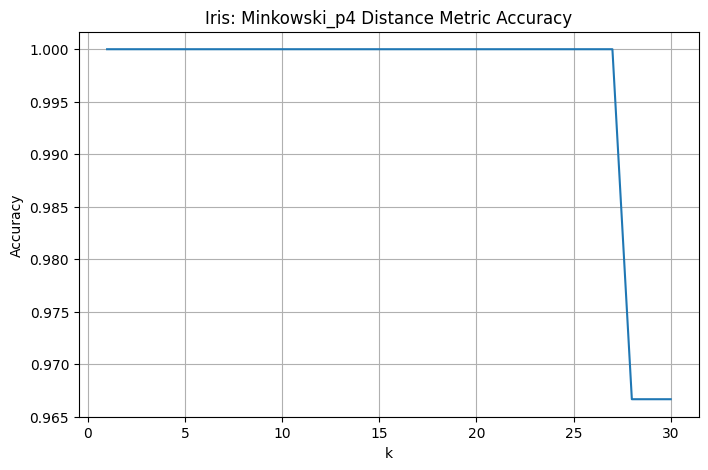

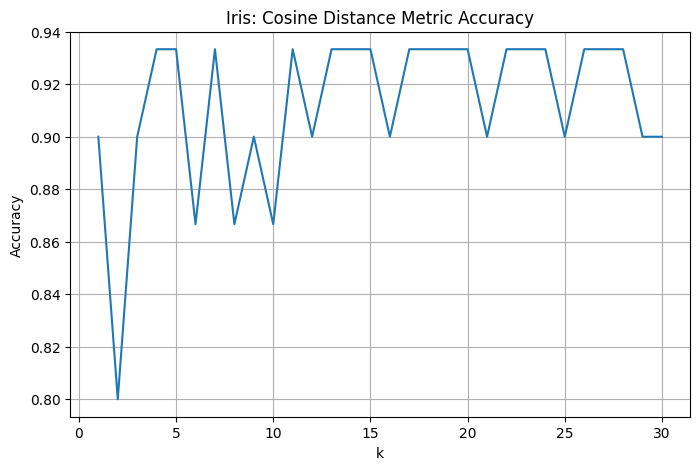

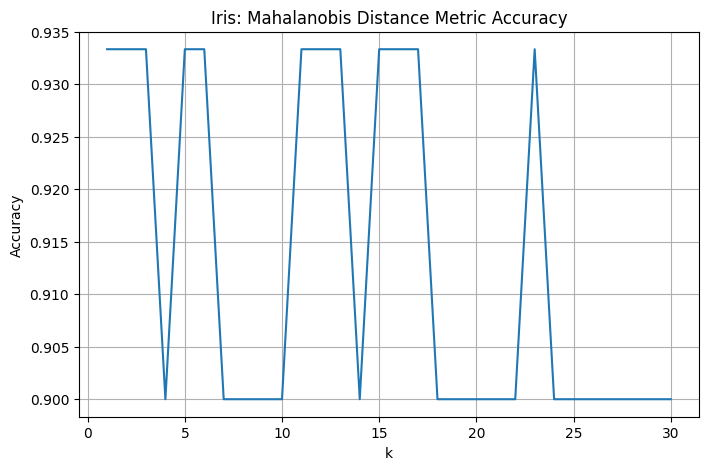

In [8]:
for name, acc in results.items():
    plt.figure(figsize=(8,5))
    plt.plot(k_values, acc)
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(f"Iris: {name.capitalize()} Distance Metric Accuracy")
    plt.grid(True)
    plt.savefig(f"Plots/Accuracy_Curves/iris_{name}_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

Cross Validation With Pipeline

In [9]:
def make_pipeline(metric, p=None, V=None):
    if metric == 'minkowski':
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric='minkowski', p=p))
        ])
    elif metric == 'mahalanobis':
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric='mahalanobis', metric_params={'V': V}))
        ])
    else:
        return Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(metric=metric))
        ])

cv_results = {}
for name, metric in distance_metrics_full.items():
    cv_scores_list = []
    for k in k_values:
        if isinstance(metric, dict) and name.startswith('minkowski'):
            pipe = make_pipeline('minkowski', p=metric['p'])
        elif name == 'mahalanobis':
            pipe = make_pipeline('mahalanobis', V=cov)
        else:
            pipe = make_pipeline(metric)

        pipe.named_steps['knn'].n_neighbors = k
        scores = cross_val_score(pipe, X, y, cv=5)
        cv_scores_list.append(np.mean(scores))
    cv_results[name] = cv_scores_list

Individual Cross Validation Plots

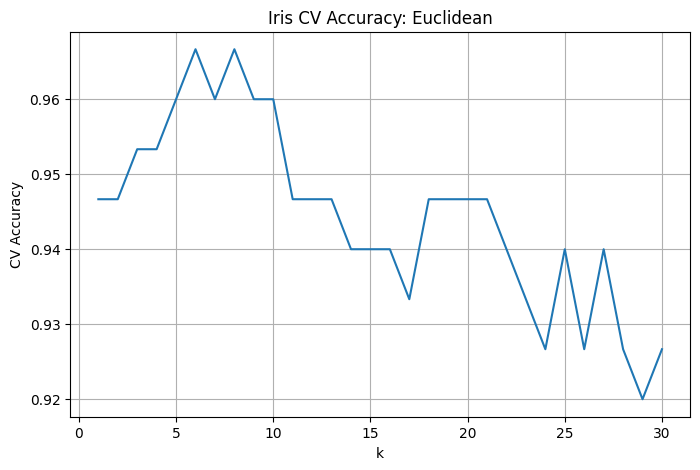

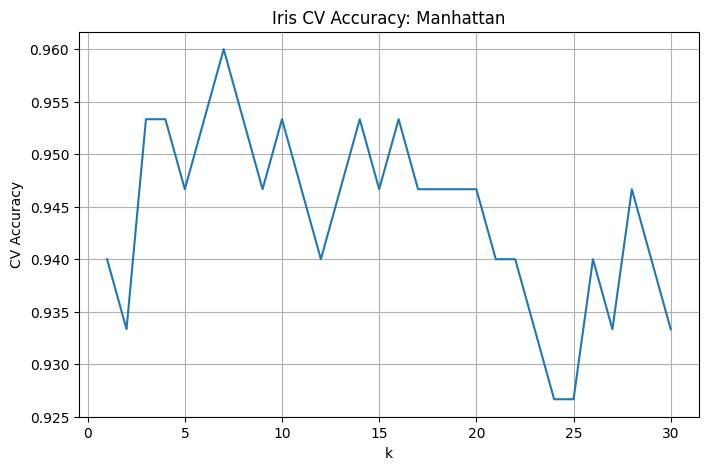

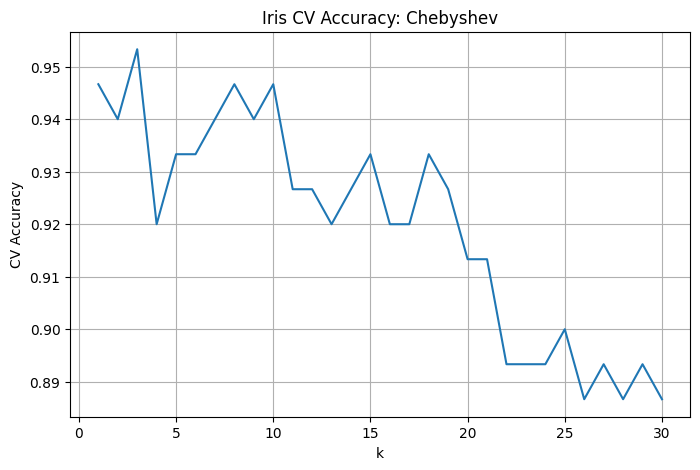

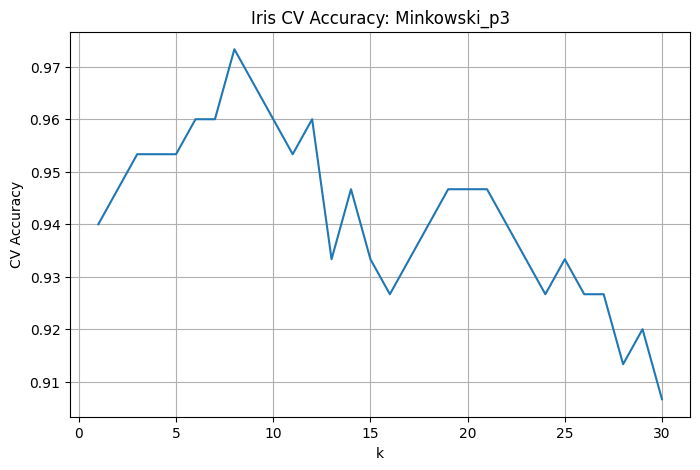

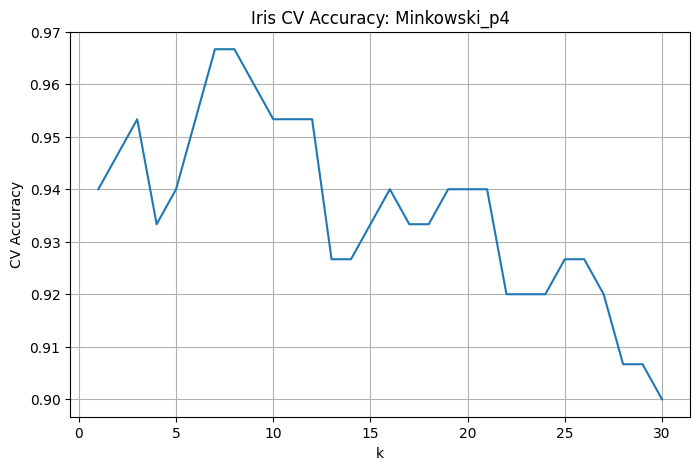

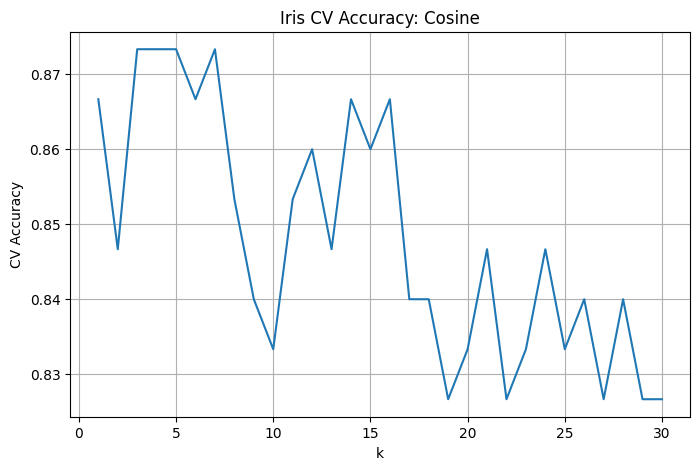

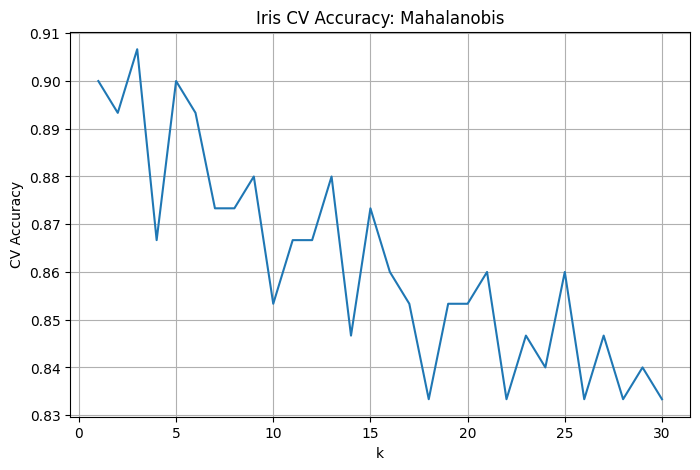

In [10]:
for name, scores in cv_results.items():
    plt.figure(figsize=(8,5))
    plt.plot(k_values, scores)
    plt.xlabel("k")
    plt.ylabel("CV Accuracy")
    plt.title(f"Iris CV Accuracy: {name.capitalize()}")
    plt.grid(True)
    plt.savefig(f"Plots/Cross_Validation_Plots/iris_cv_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

Confusion Matrices

In [11]:
conf_mats = {}
for name, acc_list in results.items():
    best_k = np.argmax(acc_list) + 1
    metric = distance_metrics_full[name]

    if isinstance(metric, dict) and name.startswith('minkowski'):
        knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric['metric'], p=metric['p'])
    elif name == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=best_k, metric='mahalanobis', metric_params={'V': cov})
    else:
        knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)

    knn.fit(X_train_std, y_train)
    preds = knn.predict(X_test_std)
    cm = confusion_matrix(y_test, preds)
    conf_mats[name] = cm

Individual Plots of Confusion Matrices

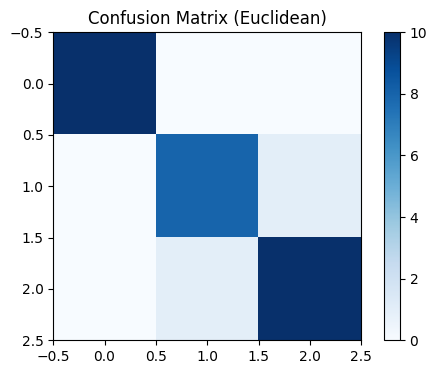

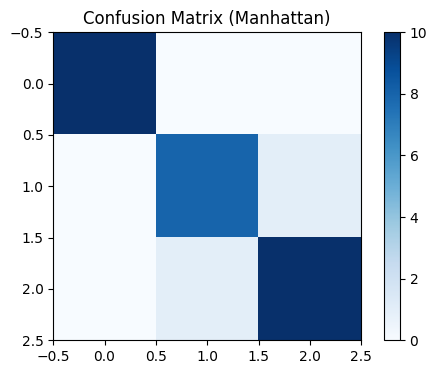

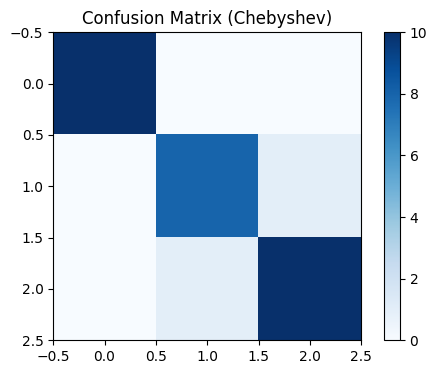

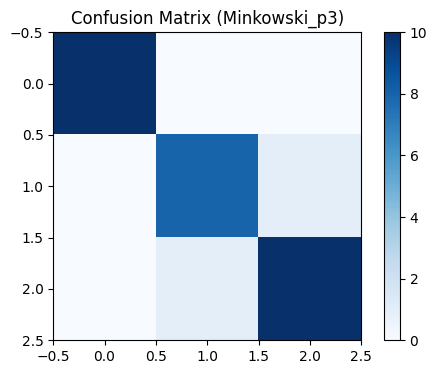

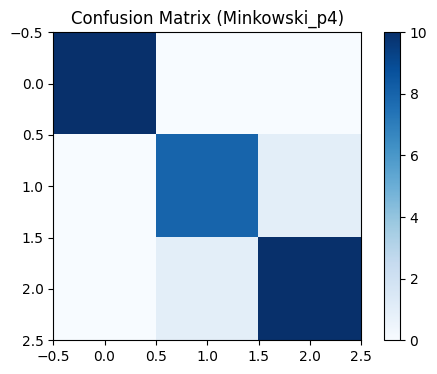

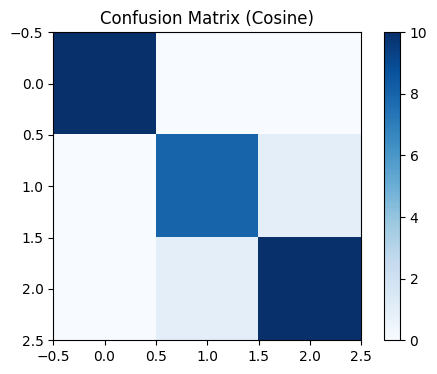

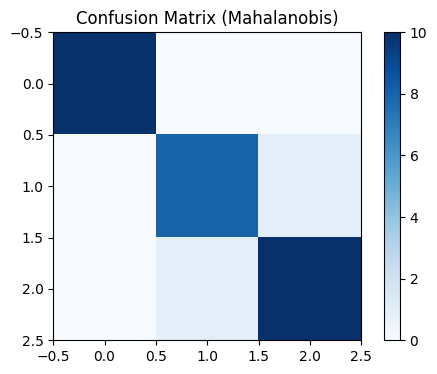

In [12]:
for name, acc_list in results.items():
    plt.figure(figsize=(6,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"Confusion Matrix ({name.capitalize()})")
    plt.colorbar()
    plt.savefig(f"Plots/Confusion_Matrices/iris_confusion_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

Results Summary

In [13]:
best_acc = {name: np.max(acc_list) for name, acc_list in results.items()}
best_k = {name: np.argmax(acc_list) + 1 for name, acc_list in results.items()}
summary_df = pd.DataFrame({'Best Accuracy': best_acc, 'Best k': best_k})
display(summary_df)

,Best Accuracy,Best k
euclidean,1.000000,1
manhattan,1.000000,2
chebyshev,1.000000,1
minkowski_p3,1.000000,1
minkowski_p4,1.000000,1
cosine,0.933333,4
mahalanobis,0.933333,1
